<a href="https://colab.research.google.com/github/SamudiniD/Efficient-Denoising-for-single-band-astronomical-images/blob/U-Net_AttentionMechanism/U_Net_FPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - loss: 0.3594 - val_loss: 0.0510
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2752 - val_loss: 0.0512
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.2078 - val_loss: 0.0495
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1497 - val_loss: 0.0471
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.1123 - val_loss: 0.0473
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0908 - val_loss: 0.0467
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0787 - val_loss: 0.0455
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0719 - val_loss: 0.0454
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0666 - val_loss: 0.0447
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0629 - val_loss: 0.0445
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0608 - val_loss: 0.0435
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/st

✅ Model trained and saved!


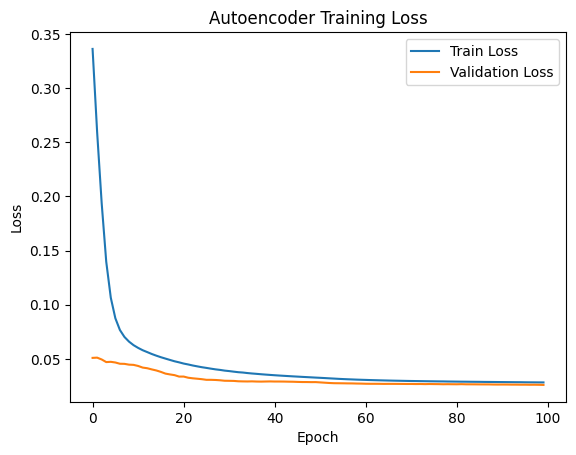

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Autoencoder Model (No Attention)
# -------------------------------
def build_autoencoder(input_shape=(240, 240, 1), num_filters=64, depth=9, dropout_rate=0.2):
    inp = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    for _ in range(depth - 2):
        x = layers.Conv2D(num_filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Decoder
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(1, 3, padding="same")(x)  # Output layer

    out = layers.Subtract()([inp, x])  # Subtract residual noise (denoising)
    return models.Model(inp, out)

# -------------------------------
# 3. Model Compilation and Training
# -------------------------------
model = build_autoencoder()
model.compile(optimizer=optimizers.Adam(1e-5), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback (stop training if validation loss doesn't improve)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best weights when training stops
                               verbose=1)

# -------------------------------
# 4. Train the Model
# -------------------------------
# Load and augment dataset
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping]  # Add early stopping here
)

# -------------------------------
# 5. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/autoencoder_t1.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 6. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -------------------------------
# 7. Evaluate the Model on Test Data (Metrics: PSNR, SSIM)
# -------------------------------

def evaluate_metrics(noisy_img, denoised_img, clean_img):
    # PSNR (Peak Signal-to-Noise Ratio)
    psnr = psnr_metric(clean_img, denoised_img, data_range=1.0)

    # SSIM (Structural Similarity Index)
    ssim = ssim_metric(clean_img, denoised_img, data_range=1.0)

    # MSE (Mean Squared Error)
    mse = np.mean((clean_img.flatten() - denoised_img.flatten()) ** 2)

    return psnr, ssim, mse

# -------------------------------
# 8. Load the Model and Evaluate
# -------------------------------
# Load the saved model
model = models.load_model("/content/drive/MyDrive/PS1_Models/autoencoder_t1.h5")
print("✅ Model loaded for evaluation!")

# Example: Evaluate on a single image (replace with your actual test data)
noisy_img = X[0]  # Use the first image in the dataset for testing
clean_img = Y[0]  # Ground truth clean image
denoised_img = model.predict(noisy_img[np.newaxis, ..., np.newaxis])[0, ..., 0]  # Denoised output

# Resize denoised image to match clean image shape (if needed)
denoised_img_resized = tf.image.resize(denoised_img, (clean_img.shape[0], clean_img.shape[1])).numpy()

# Evaluate metrics
psnr, ssim, mse = evaluate_metrics(noisy_img, denoised_img_resized, clean_img)

print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"MSE: {mse:.4f}")


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - loss: 0.1329 - val_loss: 0.0467
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0609 - val_loss: 0.0506
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0496 - val_loss: 0.0552
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0440 - val_loss: 0.0555
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0401 - val_loss: 0.0634
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0373 - val_loss: 0.0638
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0350 - val_loss: 0.0729
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0334 - val_loss: 0.0621
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0321 - val_loss: 0.0475
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0319 - val_loss: 0.0404
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.0308 - val_loss: 0.0352
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/st

✅ Model trained and saved!


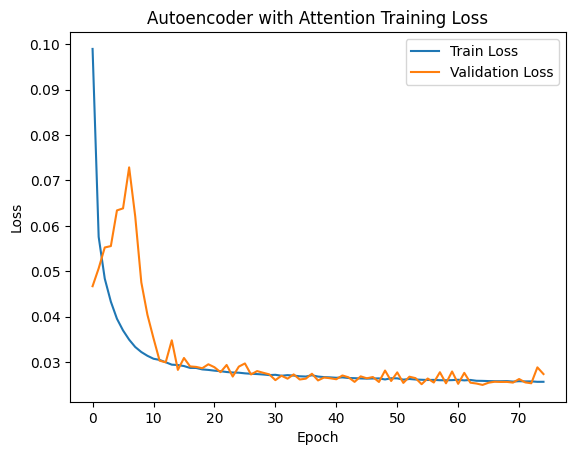

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import peak_signal_noise_ratio as psnr_metric
from skimage.metrics import structural_similarity as ssim_metric

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Attention Layer
# -------------------------------
class AttentionLayer(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)  # (batch_size, height, width, channels // 8)
        key = self.key(inputs)  # (batch_size, height, width, channels // 8)
        value = self.value(inputs)  # (batch_size, height, width, channels)

        # Calculate attention scores (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, height*width, height*width)
        attention_scores = self.softmax(attention_scores)  # Apply softmax for attention distribution

        # Calculate the weighted sum of value based on attention scores
        context = tf.matmul(attention_scores, value)  # (batch_size, height*width, channels)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. Autoencoder Model with Attention Mechanism
# -------------------------------
def build_autoencoder(input_shape=(240, 240, 1), num_filters=64, depth=9, dropout_rate=0.2):
    inp = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    for _ in range(depth - 2):
        x = layers.Conv2D(num_filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    # Apply attention layer to focus on important parts of the image
    x = AttentionLayer(num_filters)(x)  # Attention mechanism

    # Decoder
    x = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(1, 3, padding="same")(x)  # Output layer

    out = layers.Subtract()([inp, x])  # Subtract residual noise (denoising)
    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training
# -------------------------------
model = build_autoencoder()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback (stop training if validation loss doesn't improve)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,  # Number of epochs to wait for improvement
                               restore_best_weights=True,  # Restore the best weights when training stops
                               verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
# Load and augment dataset
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping]  # Add early stopping here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/autoencoder_with_attention_model.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ PSNR: 12.96 dB
✅ SSIM: 0.3314


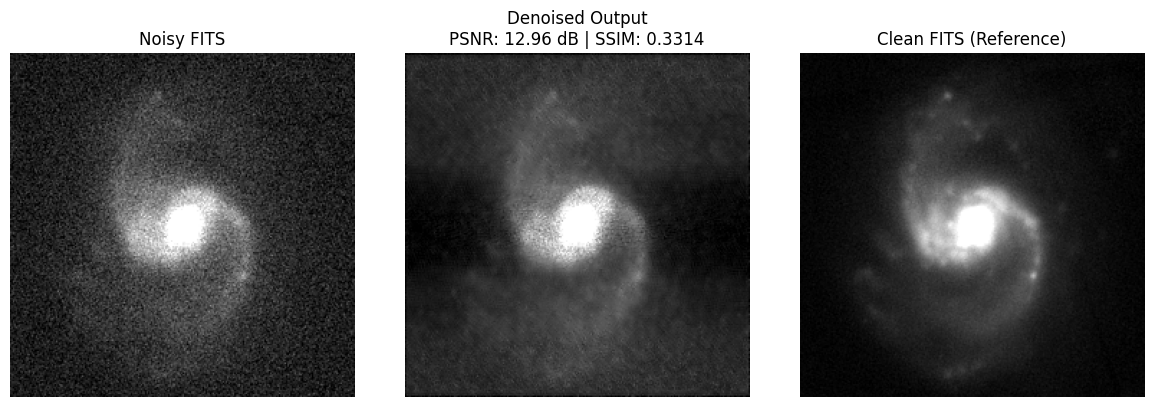

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. File paths
# -------------------------------
clean_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
autoencoder_model_path = "/content/drive/MyDrive/PS1_Models/autoencoder_with_attention_model.h5"

# -------------------------------
# 2. Register Custom Layers and Loss Functions
# -------------------------------
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)  # (batch_size, height, width, channels // 8)
        key = self.key(inputs)  # (batch_size, height, width, channels // 8)
        value = self.value(inputs)  # (batch_size, height, width, channels)

        # Calculate attention scores (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, height*width, height*width)
        attention_scores = self.softmax(attention_scores)  # Apply softmax for attention distribution

        # Calculate the weighted sum of value based on attention scores
        context = tf.matmul(attention_scores, value)  # (batch_size, height*width, channels)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. Preprocess the FITS image
# -------------------------------
def preprocess_fits(path, target_size=(240, 240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infinite values
        p1, p99 = np.percentile(data, (1, 99))  # Clip the data
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-8)  # Normalize to range [0, 1]
        data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()  # Resize image
        return data

# -------------------------------
# 4. Load the trained model (Autoencoder with Attention)
# -------------------------------
model = load_model(autoencoder_model_path, custom_objects={'AttentionLayer': AttentionLayer, 'mse': losses.MeanSquaredError})

# -------------------------------
# 5. Load and preprocess the FITS images
# -------------------------------
clean_img = preprocess_fits(clean_fits_path)
noisy_img = preprocess_fits(noisy_fits_path)

# -------------------------------
# 6. Predict denoised image using the autoencoder model
# -------------------------------
input_tensor = noisy_img[np.newaxis, ..., np.newaxis]  # Adding batch dimension and channel dimension
denoised_img = model.predict(input_tensor)[0, ..., 0]  # Get the denoised image

# -------------------------------
# 7. Compute PSNR & SSIM between the clean image and the denoised image
# -------------------------------
psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)
ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

# Print the results
print(f"✅ PSNR: {psnr:.2f} dB")
print(f"✅ SSIM: {ssim:.4f}")

# -------------------------------
# 8. Visualize the results: Noisy | Denoised | Clean
# -------------------------------
plt.figure(figsize=(12, 4))

# Noisy image
plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap='gray', vmin=np.percentile(noisy_img, 1), vmax=np.percentile(noisy_img, 99))
plt.title("Noisy FITS")
plt.axis('off')

# Denoised image
plt.subplot(1, 3, 2)
plt.imshow(denoised_img, cmap='gray', vmin=np.percentile(denoised_img, 1), vmax=np.percentile(denoised_img, 99))
plt.title(f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
plt.axis('off')

# Clean image (reference)
plt.subplot(1, 3, 3)
plt.imshow(clean_img, cmap='gray', vmin=np.percentile(clean_img, 1), vmax=np.percentile(clean_img, 99))
plt.title("Clean FITS (Reference)")
plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - loss: 0.0901 - val_loss: 0.0262
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0262 - val_loss: 0.0258
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0255 - val_loss: 0.0251
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0249 - val_loss: 0.0250
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0249 - val_loss: 0.0251
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0255 - val_loss: 0.0255
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0253 - val_loss: 0.0249
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0248 - val_loss: 0.0249
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0250 - val_loss: 0.0248
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0248 - val_loss: 0.0248
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/st

✅ Model trained and saved!


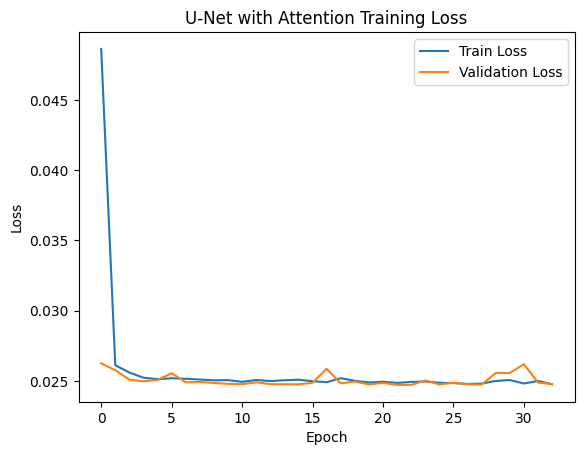

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Attention Layer
# -------------------------------
class AttentionLayer(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. U-Net Model with Attention Mechanism
# -------------------------------
def build_unet(input_shape=(240, 240, 1), num_filters=64, dropout_rate=0.2):
    inp = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x1)
    x2 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x3 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)
    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)

    # Attention mechanism (after the encoder)
    x3 = AttentionLayer(num_filters * 4)(x3)

    # Decoder (Expanding Path)
    x4 = layers.Conv2DTranspose(num_filters * 2, 3, strides=2, padding="same", activation="relu")(x3)
    x4 = layers.concatenate([x4, x2])
    x4 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x4)

    x5 = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same", activation="relu")(x4)
    x5 = layers.concatenate([x5, x1])
    x5 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x5)

    # Output layer
    out = layers.Conv2D(1, 3, padding="same")(x5)

    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training
# -------------------------------
model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback (stop training if validation loss doesn't improve)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping]  # Add early stopping here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("U-Net with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ PSNR: 17.16 dB
✅ SSIM: 0.4910


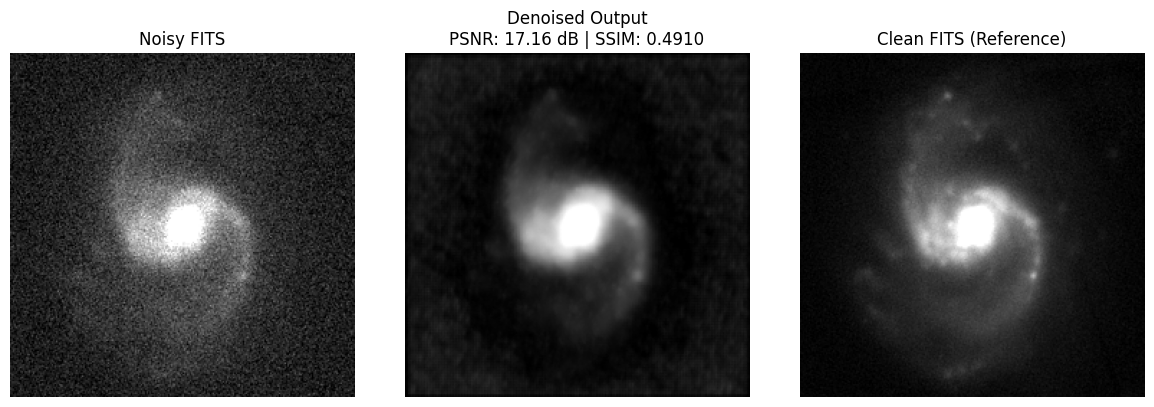

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Attention Layer (Self Attention)
# -------------------------------
class AttentionLayer(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. U-Net Model with Attention and Residual Learning
# -------------------------------
def build_unet(input_shape=(240, 240, 1), num_filters=64, dropout_rate=0.2):
    inp = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x1)
    x2 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x3 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)
    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)

    # Attention mechanism (after the encoder)
    x3 = AttentionLayer(num_filters * 4)(x3)

    # Decoder (Expanding Path)
    x4 = layers.Conv2DTranspose(num_filters * 2, 3, strides=2, padding="same", activation="relu")(x3)
    x4 = layers.concatenate([x4, x2])
    x4 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x4)

    x5 = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same", activation="relu")(x4)
    x5 = layers.concatenate([x5, x1])
    x5 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x5)

    # Output layer (Residual learning)
    out = layers.Conv2D(1, 3, padding="same")(x5)

    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training with Hyperparameter Tuning
# -------------------------------
model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback (stop training if validation loss doesn't improve)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping, lr_scheduler]  # Add early stopping and learning rate scheduler here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("U-Net with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -------------------------------
# 8. Evaluate the Model on Test Data (Metrics: PSNR, SSIM)
# -------------------------------
def evaluate_metrics(noisy_img, denoised_img, clean_img):
    # PSNR (Peak Signal-to-Noise Ratio)
    psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)

    # SSIM (Structural Similarity Index)
    ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

    # MSE (Mean Squared Error)
    mse = np.mean((clean_img.flatten() - denoised_img.flatten()) ** 2)

    return psnr, ssim, mse

# Load the saved model
model = models.load_model("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model loaded for evaluation!")

# Example: Evaluate on a single image (replace with your actual test data)
noisy_img = X[0]  # Use the first image in the dataset for testing
clean_img = Y[0]  # Ground truth clean image
denoised_img = model.predict(noisy_img[np.newaxis, ..., np.newaxis])[0, ..., 0]  # Denoised output

# Evaluate metrics
psnr, ssim, mse = evaluate_metrics(noisy_img, denoised_img, clean_img)

print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"MSE: {mse:.4f}")


In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
!pip install --upgrade tensorflow-addons


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - loss: 0.1405 - val_loss: 0.0266 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0267 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0258 - val_loss: 0.0253 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0248 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0250 - val_loss: 0.0248 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0255 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0251 - val_loss: 0.0249 - learning_rate: 1.0000e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0251 - val_loss: 0.0250 - learning_rate: 1.0000e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0252 - val_loss: 0.0248 

✅ Model trained and saved!


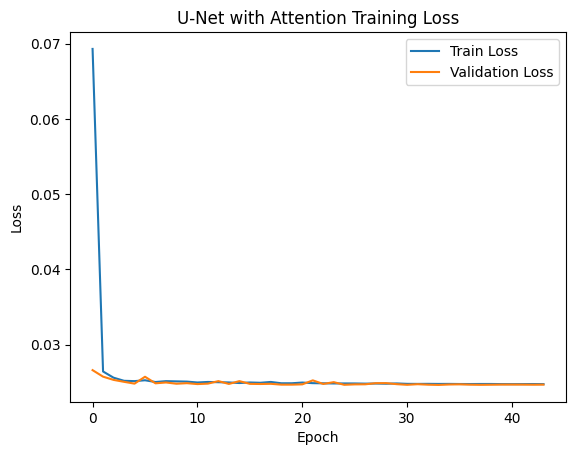

ValueError: Unknown layer: 'AttentionLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Attention Layer (Self Attention)
# -------------------------------
class AttentionLayer(layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. U-Net Model with Attention and Residual Learning
# -------------------------------
def build_unet(input_shape=(240, 240, 1), num_filters=64, dropout_rate=0.2):
    inp = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x1)
    x2 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x3 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)
    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)

    # Attention mechanism (after the encoder)
    x3 = AttentionLayer(num_filters * 4)(x3)

    # Decoder (Expanding Path)
    x4 = layers.Conv2DTranspose(num_filters * 2, 3, strides=2, padding="same", activation="relu")(x3)
    x4 = layers.concatenate([x4, x2])
    x4 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x4)

    x5 = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same", activation="relu")(x4)
    x5 = layers.concatenate([x5, x1])
    x5 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x5)

    # Output layer (Residual learning)
    out = layers.Conv2D(1, 3, padding="same")(x5)

    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training with Hyperparameter Tuning
# -------------------------------
model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback (stop training if validation loss doesn't improve)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping, lr_scheduler]  # Add early stopping and learning rate scheduler here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("U-Net with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# -------------------------------
# 8. Evaluate the Model on Test Data (Metrics: PSNR, SSIM)
# -------------------------------
def evaluate_metrics(noisy_img, denoised_img, clean_img):
    # PSNR (Peak Signal-to-Noise Ratio)
    psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)

    # SSIM (Structural Similarity Index)
    ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

    # MSE (Mean Squared Error)
    mse = np.mean((clean_img.flatten() - denoised_img.flatten()) ** 2)

    return psnr, ssim, mse

# Load the saved model
model = models.load_model("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model loaded for evaluation!")

# Example: Evaluate on a single image (replace with your actual test data)
noisy_img = X[0]  # Use the first image in the dataset for testing
clean_img = Y[0]  # Ground truth clean image
denoised_img = model.predict(noisy_img[np.newaxis, ..., np.newaxis])[0, ..., 0]  # Denoised output

# Evaluate metrics
psnr, ssim, mse = evaluate_metrics(noisy_img, denoised_img, clean_img)

print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")
print(f"MSE: {mse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ PSNR: 16.71 dB
✅ SSIM: 0.4772


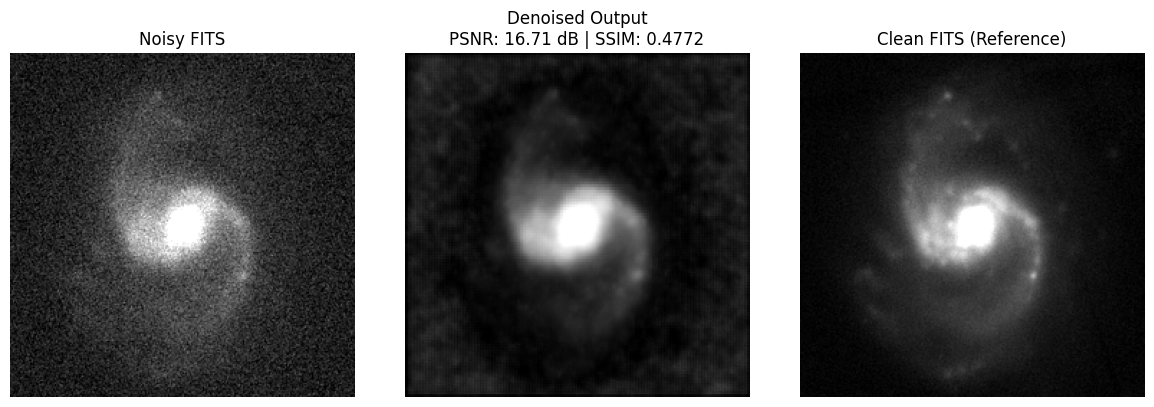

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. File paths
# -------------------------------
clean_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
autoencoder_model_path = "/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5"

# -------------------------------
# 2. Register Custom Layers and Loss Functions
# -------------------------------
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)  # (batch_size, height, width, channels // 8)
        key = self.key(inputs)  # (batch_size, height, width, channels // 8)
        value = self.value(inputs)  # (batch_size, height, width, channels)

        # Calculate attention scores (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, height*width, height*width)
        attention_scores = self.softmax(attention_scores)  # Apply softmax for attention distribution

        # Calculate the weighted sum of value based on attention scores
        context = tf.matmul(attention_scores, value)  # (batch_size, height*width, channels)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. Preprocess the FITS image
# -------------------------------
def preprocess_fits(path, target_size=(240, 240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infinite values
        p1, p99 = np.percentile(data, (1, 99))  # Clip the data
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-8)  # Normalize to range [0, 1]
        data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()  # Resize image
        return data

# -------------------------------
# 4. Load the trained model (Autoencoder with Attention)
# -------------------------------
model = load_model(autoencoder_model_path, custom_objects={'AttentionLayer': AttentionLayer, 'mse': losses.MeanSquaredError})

# -------------------------------
# 5. Load and preprocess the FITS images
# -------------------------------
clean_img = preprocess_fits(clean_fits_path)
noisy_img = preprocess_fits(noisy_fits_path)

# -------------------------------
# 6. Predict denoised image using the autoencoder model
# -------------------------------
input_tensor = noisy_img[np.newaxis, ..., np.newaxis]  # Adding batch dimension and channel dimension
denoised_img = model.predict(input_tensor)[0, ..., 0]  # Get the denoised image

# -------------------------------
# 7. Compute PSNR & SSIM between the clean image and the denoised image
# -------------------------------
psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)
ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

# Print the results
print(f"✅ PSNR: {psnr:.2f} dB")
print(f"✅ SSIM: {ssim:.4f}")

# -------------------------------
# 8. Visualize the results: Noisy | Denoised | Clean
# -------------------------------
plt.figure(figsize=(12, 4))

# Noisy image
plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap='gray', vmin=np.percentile(noisy_img, 1), vmax=np.percentile(noisy_img, 99))
plt.title("Noisy FITS")
plt.axis('off')

# Denoised image
plt.subplot(1, 3, 2)
plt.imshow(denoised_img, cmap='gray', vmin=np.percentile(denoised_img, 1), vmax=np.percentile(denoised_img, 99))
plt.title(f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
plt.axis('off')

# Clean image (reference)
plt.subplot(1, 3, 3)
plt.imshow(clean_img, cmap='gray', vmin=np.percentile(clean_img, 1), vmax=np.percentile(clean_img, 99))
plt.title("Clean FITS (Reference)")
plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - loss: 0.0884 - val_loss: 0.0264 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0263 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0252 - val_loss: 0.0253 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0250 - val_loss: 0.0250 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0253 - val_loss: 0.0249 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0249 - val_loss: 0.0249 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0253 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0251 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 9/100
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0251
Epoch 9: ReduceLROn

✅ Model trained and saved!


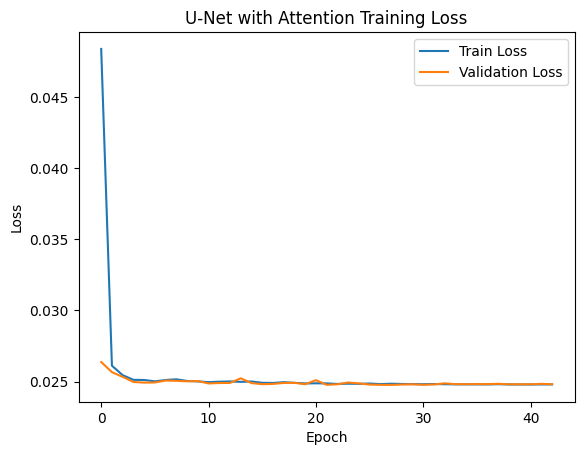

ValueError: Unknown layer: 'MultiHeadAttentionLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Multi-Head Attention Layer
# -------------------------------
class MultiHeadAttentionLayer(layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.num_heads = num_heads
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        # Split query, key, value into multiple heads
        query = tf.concat(tf.split(query, self.num_heads, axis=-1), axis=-1)
        key = tf.concat(tf.split(key, self.num_heads, axis=-1), axis=-1)
        value = tf.concat(tf.split(value, self.num_heads, axis=-1), axis=-1)

        # Attention mechanism (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. U-Net Model with Attention and Residual Learning
# -------------------------------
def build_unet(input_shape=(240, 240, 1), num_filters=64, dropout_rate=0.3):
    inp = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x1)
    x2 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x3 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)
    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)

    # Multi-Head Attention Mechanism (after the encoder)
    x3 = MultiHeadAttentionLayer(num_filters * 4)(x3)

    # Decoder (Expanding Path)
    x4 = layers.Conv2DTranspose(num_filters * 2, 3, strides=2, padding="same", activation="relu")(x3)
    x4 = layers.concatenate([x4, x2])
    x4 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x4)

    x5 = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same", activation="relu")(x4)
    x5 = layers.concatenate([x5, x1])
    x5 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x5)

    # Output layer (Residual learning)
    out = layers.Conv2D(1, 3, padding="same")(x5)

    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training with Hyperparameter Tuning
# -------------------------------
model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping, lr_scheduler]  # Add early stopping and learning rate scheduler here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("U-Net with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
✅ PSNR: 17.33 dB
✅ SSIM: 0.4882


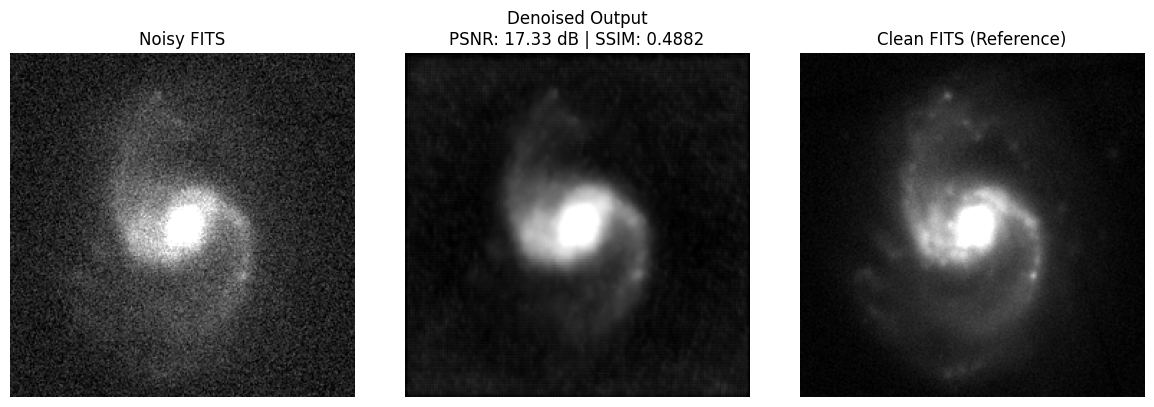

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# 1. File paths
# -------------------------------
clean_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
autoencoder_model_path = "/content/drive/MyDrive/PS1_Models/unet_with_attention_model.h5"

# -------------------------------
# 2. Register Custom Layers and Loss Functions
# -------------------------------
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)  # (batch_size, height, width, channels // 8)
        key = self.key(inputs)  # (batch_size, height, width, channels // 8)
        value = self.value(inputs)  # (batch_size, height, width, channels)

        # Calculate attention scores (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, height*width, height*width)
        attention_scores = self.softmax(attention_scores)  # Apply softmax for attention distribution

        # Calculate the weighted sum of value based on attention scores
        context = tf.matmul(attention_scores, value)  # (batch_size, height*width, channels)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.num_heads = num_heads
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        # Split query, key, value into multiple heads
        query = tf.concat(tf.split(query, self.num_heads, axis=-1), axis=-1)
        key = tf.concat(tf.split(key, self.num_heads, axis=-1), axis=-1)
        value = tf.concat(tf.split(value, self.num_heads, axis=-1), axis=-1)

        # Attention mechanism (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. Preprocess the FITS image
# -------------------------------
def preprocess_fits(path, target_size=(240, 240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infinite values
        p1, p99 = np.percentile(data, (1, 99))  # Clip the data
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-8)  # Normalize to range [0, 1]
        data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()  # Resize image
        return data

# -------------------------------
# 4. Load the trained model (Autoencoder with Attention)
# -------------------------------
# Ensure the custom layers are properly registered when loading the model
model = load_model(autoencoder_model_path, custom_objects={
    'AttentionLayer': AttentionLayer,
    'MultiHeadAttentionLayer': MultiHeadAttentionLayer,
    'mse': losses.MeanSquaredError
})

# -------------------------------
# 5. Load and preprocess the FITS images
# -------------------------------
clean_img = preprocess_fits(clean_fits_path)
noisy_img = preprocess_fits(noisy_fits_path)

# -------------------------------
# 6. Predict denoised image using the autoencoder model
# -------------------------------
input_tensor = noisy_img[np.newaxis, ..., np.newaxis]  # Adding batch dimension and channel dimension
denoised_img = model.predict(input_tensor)[0, ..., 0]  # Get the denoised image

# -------------------------------
# 7. Compute PSNR & SSIM between the clean image and the denoised image
# -------------------------------
psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)
ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

# Print the results
print(f"✅ PSNR: {psnr:.2f} dB")
print(f"✅ SSIM: {ssim:.4f}")

# -------------------------------
# 8. Visualize the results: Noisy | Denoised | Clean
# -------------------------------
plt.figure(figsize=(12, 4))

# Noisy image
plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap='gray', vmin=np.percentile(noisy_img, 1), vmax=np.percentile(noisy_img, 99))
plt.title("Noisy FITS")
plt.axis('off')

# Denoised image
plt.subplot(1, 3, 2)
plt.imshow(denoised_img, cmap='gray', vmin=np.percentile(denoised_img, 1), vmax=np.percentile(denoised_img, 99))
plt.title(f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
plt.axis('off')

# Clean image (reference)
plt.subplot(1, 3, 3)
plt.imshow(clean_img, cmap='gray', vmin=np.percentile(clean_img, 1), vmax=np.percentile(clean_img, 99))
plt.title("Clean FITS (Reference)")
plt.axis('off')

plt.tight_layout()
plt.show()


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - loss: 0.1009 - val_loss: 0.0262 - learning_rate: 1.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0263 - val_loss: 0.0262 - learning_rate: 1.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0257 - val_loss: 0.0254 - learning_rate: 1.0000e-04
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0254 - val_loss: 0.0257 - learning_rate: 1.0000e-04
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0257 - val_loss: 0.0250 - learning_rate: 1.0000e-04
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0251 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0250 - val_loss: 0.0252 - learning_rate: 1.0000e-04
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0252 - val_loss: 0.0255 - learning_rate: 1.0000e-04
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0254 - val_loss: 0.0249 

✅ Model trained and saved!


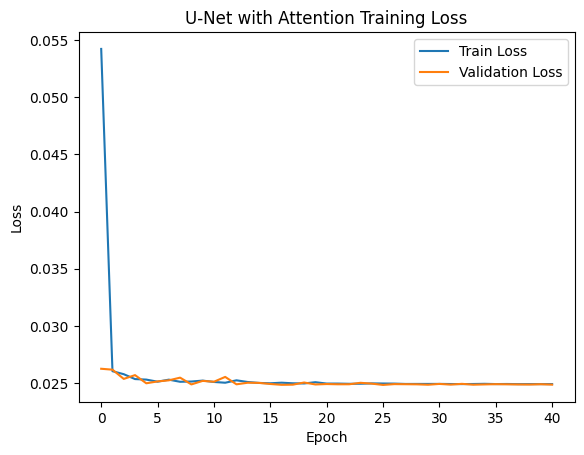

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# -------------------------------
# 1. Dataset Loading and Augmentation
# -------------------------------
def load_dataset():
    # Load noisy and clean images (replace with your actual dataset path)
    X = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/noisy.npy")  # Noisy images
    Y = np.load("/content/drive/MyDrive/SDSS_augmented_npy/train/clean.npy")  # Clean images

    # Normalize the images (clip between 0 and 1)
    X = np.clip(X, 0, 1).astype(np.float32)
    Y = np.clip(Y, 0, 1).astype(np.float32)

    # Add channel dimension if necessary (e.g., for grayscale images)
    if X.ndim == 3:
        X = X[..., np.newaxis]
    if Y.ndim == 3:
        Y = Y[..., np.newaxis]

    return X, Y

# Data Augmentation Functions
def add_gaussian_noise(image, std=0.05):
    """Add Gaussian noise to the image."""
    return np.clip(image + np.random.normal(0, std, image.shape), 0.0, 1.0)

def add_salt_and_pepper(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt-and-pepper noise to the image."""
    noisy_image = image.copy()
    total = image.shape[0] * image.shape[1]
    num_salt = int(total * salt_prob)
    num_pepper = int(total * pepper_prob)

    # Salt
    coords = [np.random.randint(0, i, num_salt) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 1.0
    # Pepper
    coords = [np.random.randint(0, i, num_pepper) for i in image.shape[:2]]
    noisy_image[coords[0], coords[1], 0] = 0.0
    return noisy_image

def add_poisson_noise(image):
    """Add Poisson noise to the image."""
    return np.clip(np.random.poisson(image * 255) / 255.0, 0, 1)

def add_mixed_noise(image):
    """Add mixed noise (Gaussian or salt-and-pepper)."""
    return add_gaussian_noise(image, std=0.05) if np.random.rand() < 0.5 else add_salt_and_pepper(image)

# Generate noisy input-target pairs
def augment_data(X, Y):
    X_augmented = np.array([add_mixed_noise(img) for img in X])
    Y_augmented = np.array([add_mixed_noise(img) for img in Y])
    return X_augmented, Y_augmented

# -------------------------------
# 2. Multi-Head Attention Layer
# -------------------------------
class MultiHeadAttentionLayer(layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.num_heads = num_heads
        self.query = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        # Split query, key, value into multiple heads
        query = tf.concat(tf.split(query, self.num_heads, axis=-1), axis=-1)
        key = tf.concat(tf.split(key, self.num_heads, axis=-1), axis=-1)
        value = tf.concat(tf.split(value, self.num_heads, axis=-1), axis=-1)

        # Attention mechanism (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. U-Net Model with Attention and Residual Learning
# -------------------------------
def build_unet(input_shape=(240, 240, 1), num_filters=64, dropout_rate=0.3):
    inp = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(inp)
    x1 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x1)
    x2 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x2 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x2)
    x3 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)
    x3 = layers.Conv2D(num_filters * 4, 3, padding="same", activation="relu")(x3)

    # Multi-Head Attention Mechanism (after the encoder)
    x3 = MultiHeadAttentionLayer(num_filters * 4)(x3)

    # Decoder (Expanding Path)
    x4 = layers.Conv2DTranspose(num_filters * 2, 3, strides=2, padding="same", activation="relu")(x3)
    x4 = layers.concatenate([x4, x2])
    x4 = layers.Conv2D(num_filters * 2, 3, padding="same", activation="relu")(x4)

    x5 = layers.Conv2DTranspose(num_filters, 3, strides=2, padding="same", activation="relu")(x4)
    x5 = layers.concatenate([x5, x1])
    x5 = layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x5)

    # Output layer (Residual learning)
    out = layers.Conv2D(1, 3, padding="same")(x5)

    return models.Model(inp, out)

# -------------------------------
# 4. Model Compilation and Training with Hyperparameter Tuning
# -------------------------------
model = build_unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='mse')  # Using MSE loss for simplicity

# EarlyStopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

# -------------------------------
# 5. Train the Model
# -------------------------------
X, Y = load_dataset()
X_augmented, Y_augmented = augment_data(X, Y)

history = model.fit(
    X_augmented, Y_augmented,
    epochs=100,
    batch_size=16,
    validation_split=0.1,  # Split data into training and validation sets
    callbacks=[early_stopping, lr_scheduler]  # Add early stopping and learning rate scheduler here
)

# -------------------------------
# 6. Save the Trained Model
# -------------------------------
model.save("/content/drive/MyDrive/PS1_Models/unet_with_attention_model_V1.h5")
print("✅ Model trained and saved!")

# -------------------------------
# 7. Plot Training History
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("U-Net with Attention Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
✅ PSNR: 16.42 dB
✅ SSIM: 0.4790


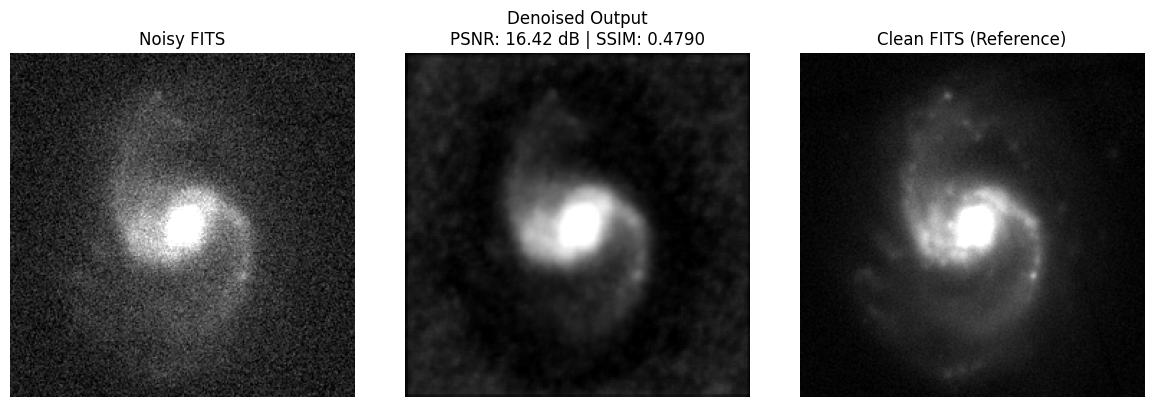

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from astropy.io import fits
from tensorflow.keras.models import load_model
from tensorflow.keras import losses
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# 1. File paths
# -------------------------------
clean_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/clean/galaxy_004_clean.fits"
noisy_fits_path = "/content/drive/MyDrive/PS1_Dataset/renamed/noisy/galaxy_004_noisy.fits"
autoencoder_model_path = "/content/drive/MyDrive/PS1_Models/unet_with_attention_model_V1.h5"  # Corrected path with uppercase V1

# -------------------------------
# 2. Register Custom Layers and Loss Functions
# -------------------------------
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)  # (batch_size, height, width, channels // 8)
        key = self.key(inputs)  # (batch_size, height, width, channels // 8)
        value = self.value(inputs)  # (batch_size, height, width, channels)

        # Calculate attention scores (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)  # (batch_size, height*width, height*width)
        attention_scores = self.softmax(attention_scores)  # Apply softmax for attention distribution

        # Calculate the weighted sum of value based on attention scores
        context = tf.matmul(attention_scores, value)  # (batch_size, height*width, channels)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, channels, num_heads=4, **kwargs):
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.channels = channels
        self.num_heads = num_heads
        self.query = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.key = tf.keras.layers.Conv2D(self.channels // 8, kernel_size=1, padding="same")
        self.value = tf.keras.layers.Conv2D(self.channels, kernel_size=1, padding="same")
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, inputs):
        query = self.query(inputs)
        key = self.key(inputs)
        value = self.value(inputs)

        # Split query, key, value into multiple heads
        query = tf.concat(tf.split(query, self.num_heads, axis=-1), axis=-1)
        key = tf.concat(tf.split(key, self.num_heads, axis=-1), axis=-1)
        value = tf.concat(tf.split(value, self.num_heads, axis=-1), axis=-1)

        # Attention mechanism (dot product of query and key)
        attention_scores = tf.matmul(query, key, transpose_b=True)
        attention_scores = self.softmax(attention_scores)

        context = tf.matmul(attention_scores, value)
        context = tf.reshape(context, (-1, tf.shape(inputs)[1], tf.shape(inputs)[2], self.channels))

        return context

# -------------------------------
# 3. Preprocess the FITS image
# -------------------------------
def preprocess_fits(path, target_size=(240, 240)):
    with fits.open(path) as hdul:
        data = hdul[0].data.astype(np.float32)
        data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)  # Handle NaNs and infinite values
        p1, p99 = np.percentile(data, (1, 99))  # Clip the data
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-8)  # Normalize to range [0, 1]
        data = tf.image.resize(data[..., np.newaxis], target_size).numpy().squeeze()  # Resize image
        return data

# -------------------------------
# 4. Load the trained model (Autoencoder with Attention)
# -------------------------------
# Ensure the custom layers are properly registered when loading the model
model = load_model(autoencoder_model_path, custom_objects={
    'AttentionLayer': AttentionLayer,
    'MultiHeadAttentionLayer': MultiHeadAttentionLayer,
    'mse': losses.MeanSquaredError
})

# -------------------------------
# 5. Load and preprocess the FITS images
# -------------------------------
clean_img = preprocess_fits(clean_fits_path)
noisy_img = preprocess_fits(noisy_fits_path)

# -------------------------------
# 6. Predict denoised image using the autoencoder model
# -------------------------------
input_tensor = noisy_img[np.newaxis, ..., np.newaxis]  # Adding batch dimension and channel dimension
denoised_img = model.predict(input_tensor)[0, ..., 0]  # Get the denoised image

# -------------------------------
# 7. Compute PSNR & SSIM between the clean image and the denoised image
# -------------------------------
psnr = peak_signal_noise_ratio(clean_img, denoised_img, data_range=1.0)
ssim = structural_similarity(clean_img, denoised_img, data_range=1.0)

# Print the results
print(f"✅ PSNR: {psnr:.2f} dB")
print(f"✅ SSIM: {ssim:.4f}")

# -------------------------------
# 8. Visualize the results: Noisy | Denoised | Clean
# -------------------------------
plt.figure(figsize=(12, 4))

# Noisy image
plt.subplot(1, 3, 1)
plt.imshow(noisy_img, cmap='gray', vmin=np.percentile(noisy_img, 1), vmax=np.percentile(noisy_img, 99))
plt.title("Noisy FITS")
plt.axis('off')

# Denoised image
plt.subplot(1, 3, 2)
plt.imshow(denoised_img, cmap='gray', vmin=np.percentile(denoised_img, 1), vmax=np.percentile(denoised_img, 99))
plt.title(f"Denoised Output\nPSNR: {psnr:.2f} dB | SSIM: {ssim:.4f}")
plt.axis('off')

# Clean image (reference)
plt.subplot(1, 3, 3)
plt.imshow(clean_img, cmap='gray', vmin=np.percentile(clean_img, 1), vmax=np.percentile(clean_img, 99))
plt.title("Clean FITS (Reference)")
plt.axis('off')

plt.tight_layout()
plt.show()
